In [1]:
import pandas as pd
import pymongo
from numba import vectorize,float64
import numpy as np
from scipy.stats import chi2_contingency,percentileofscore
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context("poster")

In [2]:
client = pymongo.MongoClient()
db = client.swatford

In [3]:
gene_uid = pd.read_pickle("../data/SSI/gene_uid.p")

In [4]:
%run equations.py

In [5]:
n = db.genes.descs.original.find().count()
gene_uid["pmi"] = pmi(gene_uid.gd_freq.values,gene_uid.d_freq.values,gene_uid.g_freq.values,n)
gene_uid["npmi"] = npmi(gene_uid.pmi.values,gene_uid.gd_freq.values,n)

In [7]:
uid_name = {doc["uid"]:doc["name"] for doc in db.medline.descs.find({})}

In [8]:
gene_uid["name"] = gene_uid.uid.map(pd.Series(uid_name))

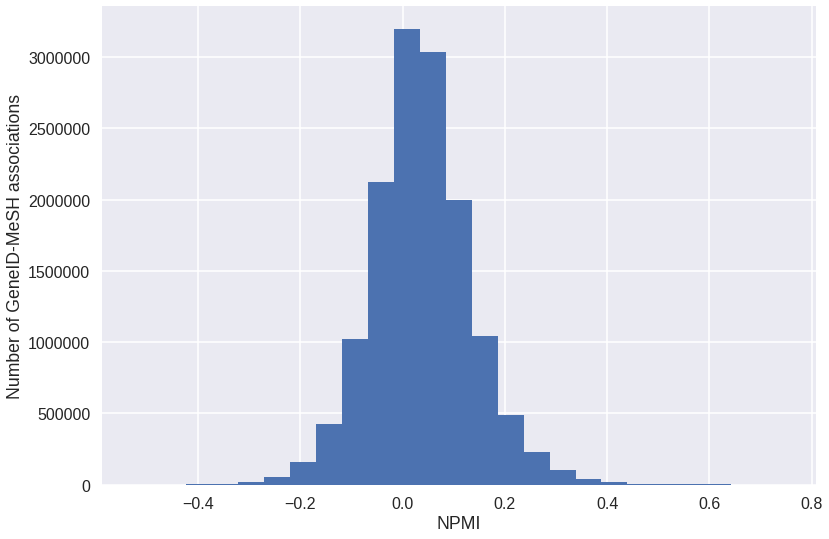

In [277]:
gene_uid.npmi.hist(bins=25)
plt.ylabel("Number of GeneID-MeSH associations")
plt.xlabel("NPMI")
plt.savefig("EMCON_NPMI_dist.jpeg",dpi=500,transparent=False,bbox_inches="tight")

In [13]:
bc_genes = pd.read_pickle("../data/SSI/ssi_gene_list.p")

In [14]:
genes = set(gene_uid.gene_id.unique())

In [15]:
random_gene_lists = np.random.choice(list(genes),(1000,len(bc_genes)))

In [16]:
bc_uids = ["D009389","D018919","D017209","D002453","D057890","D004249","D004260","D013006","D002470","D007107",
    "D007249","D001940","D001941","D018384","D049109","D012739","D015262"]

In [17]:
uid_tn = pd.DataFrame([{"uid":doc["uid"],"tn":tn} 
                       for doc in db.medline.descs.find({"tn":{"$exists":True}}) for tn in doc["tn"]])

In [18]:
bc_tns = uid_tn[uid_tn.uid.isin(bc_uids)]

In [19]:
bc_children = db.medline.descs.distinct("uid",{"ancestors":{"$in":list(bc_tns.tn.values)}})

In [20]:
bc_uids = set(bc_children)|set(bc_uids)

In [21]:
genie_genes = pd.read_table("../data/SSI/genie_results_w_children.txt")
# genie_genes = genie_genes[genie_genes.Rank<=len(bc_genes)].GeneID.unique()
genie_genes = genie_genes[genie_genes.Rank<=500].GeneID.unique()
genie_genes_bn = pd.read_table("../data/SSI/genie_results_breast_neoplasms_20170718153344381245235_table.txt")
genie_genes_bn = genie_genes_bn[genie_genes_bn.Rank<=len(bc_genes)].GeneID.unique()

In [280]:
bc_results = gene_uid[(gene_uid.uid.isin(bc_uids)) & (gene_uid.gd_freq>2)].copy()

In [281]:
bc_results["npmi_rank"] = [None]*len(bc_results)
bc_results = bc_results[["gene_id","uid","npmi","npmi_rank"]].pivot(index="gene_id",columns="uid")

In [282]:
bc_results = bc_results.swaplevel(1,0,axis=1)

In [283]:
for d in bc_results.columns.get_level_values("uid"):
    bc_results[d,"npmi"].update(pd.Series(index = bc_results[d][bc_results[d,
                                                                    "npmi"]<=0].npmi.index.values,data=np.nan))
    bc_results[d,"npmi_rank"] = bc_results[d,"npmi"].rank(ascending=False,na_option="bottom")

In [284]:
random_gene_npmi_ranks = []
for rgl in random_gene_lists:
    random_gene_npmi_ranks.append(bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[rgl].mean())

In [285]:
bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].min(),bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].max(),bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].mean()

(3683.0, 7710.022988505747, 6517.0837638671965)

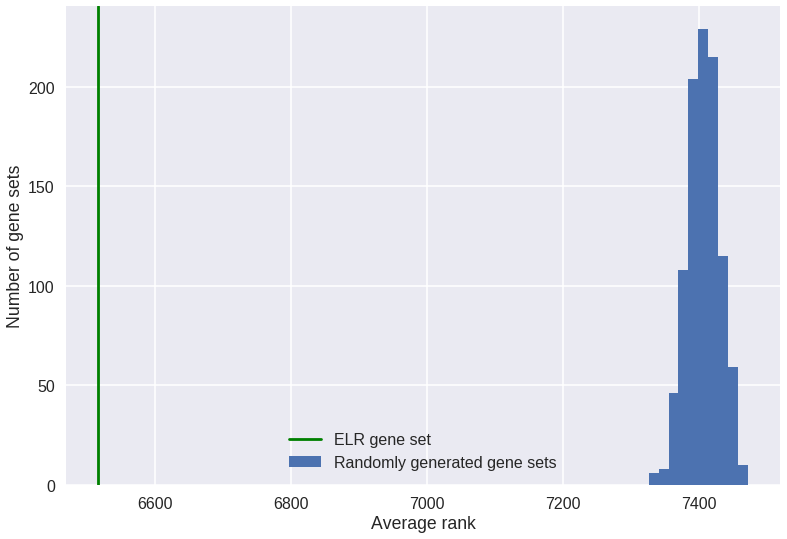

In [295]:
pd.Series(random_gene_npmi_ranks).hist(label="Randomly generated gene sets")
plt.xlabel("Average rank")
plt.ylabel("Number of gene sets")

plt.axvline(x=bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].mean(),color="g",label="ELR gene set")
plt.legend()
plt.savefig("EMCON_bc_relevance.jpeg",dpi=500,transparent=False,bbox_inches="tight")

In [ ]:
for d in bc_results.columns.get_level_values("uid"):
    print(uid_name[d])

In [296]:
set(bc_genes)-set(bc_results.index.values)

set()

In [ ]:
pd.Series(random_gene_chi2_ranks).hist()
plt.title("chi2 distribution")
plt.axvline(x=bc_results.swaplevel(0,1,axis=1).chi2_rank.mean(axis=1)[bc_genes].mean(),color="r")
print(np.percentile(random_gene_chi2_ranks,5)-bc_results.swaplevel(0,1,axis=1).chi2_rank.mean(axis=1)[bc_genes].mean())

In [ ]:
pd.Series(random_gene_ll_ranks).hist()
plt.title("log-liklihood distribution")
plt.axvline(x=bc_results.swaplevel(0,1,axis=1).ll_rank.mean(axis=1)[bc_genes].mean(),color="r")
print(np.percentile(random_gene_ll_ranks,5)-bc_results.swaplevel(0,1,axis=1).ll_rank.mean(axis=1)[bc_genes].mean())

In [ ]:
print(bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].mean(),
      bc_results.swaplevel(0,1,axis=1).chi2_rank.mean(axis=1)[bc_genes].mean(),
      bc_results.swaplevel(0,1,axis=1).ll_rank.mean(axis=1)[bc_genes].mean()
     )

In [ ]:
uids = gene_uid[gene_uid.gd_freq>2].uid.unique()

In [ ]:
random_mesh_list = np.random.choice(uids,(3000,17))

In [ ]:
random_mesh_list_w_children = []
for i,rml in enumerate(random_mesh_list):
    rml_tns = uid_tn[uid_tn.uid.isin(rml)].tn.values
    random_mesh_list_w_children.append(list(rml)+
                                       list(db.medline.descs.distinct("uid",{"ancestors":{"$in":list(rml_tns)}})))

In [ ]:
searchable_gene_uid = gene_uid[(gene_uid.gd_freq>2) 
                               & (gene_uid.uid.isin(uids))].set_index("uid",drop=False)

In [ ]:
dfs = []
while len(dfs)<10000:
    rml = list(np.random.choice(uids,17))
    rml_tns = uid_tn[uid_tn.uid.isin(rml)].tn.values
    rml+= list(db.medline.descs.distinct("uid",{"ancestors":{"$in":list(rml_tns)}}))
    try:
        df = searchable_gene_uid.loc[rml].reset_index(drop=True).pivot(index="gene_id",
                                                                             columns="uid")
#         .npmi.fillna(0.0)
#         if len(set(df.index.values)&set(bc_genes))/len(bc_genes)>=0.8:
        dfs.append(df)
        print("dfs: ",len(dfs))
    except:
        pass

In [ ]:
bc_df = searchable_gene_uid.loc[bc_uids].reset_index(drop=True)
bc_df = bc_df[bc_df.gene_id.isnull()==False].drop_duplicates().pivot(
                                                                    index="gene_id",columns="uid",values="npmi")

In [ ]:
for c in bc_df:
    bc_df[c].update(pd.Series(index=bc_df[c][bc_df[c]<0.0].index,data=0.0))
bc_rank = bc_df.rank(ascending=False,
        na_option="bottom").loc[bc_genes].mean().mean()/len(bc_df.index.unique())

In [ ]:
random_mesh_ranks = []
for df in dfs:
#     for c in df:
#         df[c].update(pd.Series(index=df[c][df[c]<0.0].index,data=0.0))
    ranks = df.rank(na_option="bottom")
    random_mesh_ranks.append(((ranks.loc[bc_genes].mean().mean())/len(ranks.index.unique())))

In [ ]:
pd.Series(random_mesh_ranks).hist(label="Random MeSH Terms")
plt.axvline(bc_rank,c="r",label="BC MeSH Terms")
plt.legend(loc="upper right")
plt.xlim(0.4,0.6)
plt.title("Query Performance of Manually Selected MeSH Terms")
plt.xlabel("Average Rank (scaled to number of genes retrieved)")
plt.ylabel("Frequency")

In [ ]:
percentileofscore(random_mesh_ranks,bc_rank)

In [ ]:
bc_gwas_genes = pd.read_table("../data/SSI/BC_GWAS_genes.txt")

In [ ]:
bc_gwas_genes = bc_gwas_genes[bc_gwas_genes.Species=="Homo sapiens"].copy()

In [ ]:
bc_gwas_genes = bc_gwas_genes.To.unique()

In [ ]:
bc_df.rank(ascending=False,
        na_option="bottom").loc[bc_gwas_genes].mean().mean()/len(bc_df.index.unique())

In [ ]:
set(bc_gwas_genes) & set(bc_genes)

In [ ]:
len(bc_gwas_genes),len(bc_genes),len(set(bc_gwas_genes) | set(bc_genes))

In [ ]:
import pickle
with open("../data/SSI/bc_uids.p","wb") as f:
    pickle.dump(bc_uids,f)

In [96]:
to_export = bc_results.swaplevel(0,1,axis=1).npmi_rank.copy()[["D009389","D018919","D017209","D002453","D057890","D004249","D004260","D013006","D002470","D007107",
    "D007249","D001940","D001941","D018384","D049109","D012739","D015262"]]

In [97]:
to_export.columns = pd.MultiIndex.from_tuples([(uid_name[x],x) for x in to_export.columns],names=["name","uid"])

In [98]:
to_export.index = pd.MultiIndex.from_tuples([(x,dict(db.genes.find_one({"gene_id":x}))["symbol"]) if x!=401388 else (7979,"SEM1") for x in to_export.index],names=["gene_id","symbol"])

In [100]:
to_export.to_csv("bc_results.csv")

In [218]:
set(bc_genes)|set(bc_results.index)

14811

In [237]:
bc_results_genes = set()
for col in bc_results.swaplevel(0,1,axis=1).npmi:
    for g in bc_results[col][bc_results[col].npmi>0.0].index:
        bc_results_genes.add(g)

In [241]:
set(bc_genes) - bc_results_genes

{148, 1812, 3361, 3362, 6531}

In [242]:
len(bc_genes)-5

282

In [308]:
gene_uid[(gene_uid.gene_id==6531)&(gene_uid.gd_freq>2)&(gene_uid.npmi>0.0)]

,gd_freq,gene_id,uid,g_freq,d_freq,pmi,npmi
7620,4,6531.0,D000071158,21306,2113,2.349784,0.098839
9290,4,6531.0,D000071679,21306,7605,0.502128,0.021121
53650,4,6531.0,D000111,21306,4766,1.176297,0.049479
59783,11,6531.0,D000200,21306,5081,2.543396,0.113980
61543,4,6531.0,D000208,21306,7638,0.495881,0.020858
121702,197,6531.0,D000293,21306,86023,2.624478,0.144585
138814,301,6531.0,D000328,21306,415345,0.964530,0.054990
155486,27,6531.0,D000367,21306,37252,0.964718,0.045898
166008,98,6531.0,D000368,21306,202931,0.378941,0.019779
179836,37,6531.0,D000369,21306,70376,0.501518,0.024388
